In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from os.path import expanduser
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout


import cv2

In [4]:
path = expanduser('~/data/bird_class/')
data_folders = ['valid', 'train', 'test']
dat = os.listdir(path) 
dat
#rename folder PARAKETT  AKULET to PARAKEET AUKLET in os because it is misspelled
for data_split in data_folders:
    for folder in os.listdir(os.path.join(path,data_split)):
        if 'PARAKETT AUKLET' in folder:
            os.rename(os.path.join(path,data_split,folder), os.path.join(path,data_split,folder.replace('PARAKETT AUKLET', 'PARAKEET AUKLET')))

In [3]:
bird_df = pd.read_csv(path + 'birds.csv')
#replace PARAKETT  AKULET with PARAKETT AUKLET in filepaths and labels
bird_df['filepaths'] = bird_df['filepaths'].str.replace('PARAKETT  AKULET', 'PARAKEET AUKLET')
bird_df['labels'] = bird_df['labels'].str.replace('PARAKETT  AKULET', 'PARAKEET AUKLET')
bird_df

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
...,...,...,...,...,...
89880,524.0,valid/BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89881,524.0,valid/BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89882,524.0,valid/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524.0,valid/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


In [4]:
#Labels to classes 
labels_dct = {}

print(len(bird_df['class id'].unique()), len(bird_df['labels'].str.lower().unique()), len(bird_df['scientific name'].str.lower().unique()))
#The lengths of the scientific names differ from the labels, so we need to find the missing scientific names

for index, val in enumerate(bird_df['class id'].unique()):
    labels_dct[index] = bird_df['labels'].str.lower().unique()[index]
labels_dct[0]

525 525 522


'abbotts babbler'

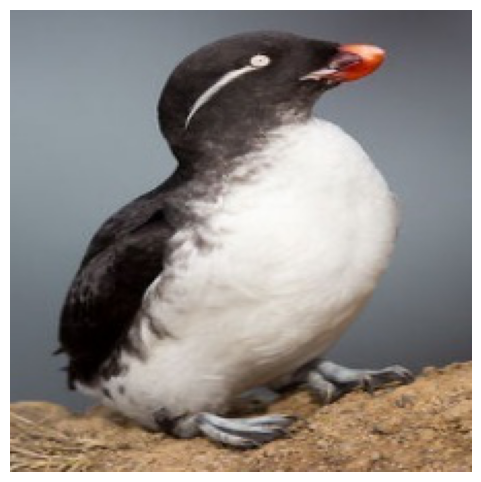

In [ ]:
def read_images_array(filepath):
    lst = cv2.imread(os.path.join(path+filepath), 1)
    return lst
img = read_images_array('/valid/PARAKEET AUKLET/1.jpg')

#converting from BGR to RGB because matplotlib reads in RGB and CV2 reads in BGR

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
ax.axis('off')
plt.show()

In [ ]:
#Manually splitting the data and saving it to a dictionary for pickling
def split_data(df):
    set_dct = {}
    file_paths = df.pop('filepaths')
    df.drop(['scientific name','labels'], axis=1, inplace=True)
    df['class id'] = df['class id'].astype(int)
    df['image'] = file_paths.apply(read_images_array)

    for item in df['data set'].unique():
        set_dct[item] = df[df['data set'] == item]
    return set_dct
data = split_data(bird_df)

#writing the file to a pickle file
with open(path+'bird.pickle', "wb") as pkl:
    pickle.dump(data, pkl, pickle.HIGHEST_PROTOCOL)

In [5]:
#Manually reading the saved pickle file
#reading the pickle file
with open(path+'bird.pickle', "rb") as pkl:
    data = pickle.load(pkl)
    
train_df = data['train']
valid_df = data['valid']
testing_df = data['test']
#drop the data set column
train_df.drop('data set', axis=1, inplace=True)
valid_df.drop('data set', axis=1, inplace=True)
testing_df.drop('data set', axis=1, inplace=True)

#merge train and valid dataframes
training_df = pd.concat([train_df, valid_df], ignore_index=True)
training_df.head()

In [62]:
#Automatically reading the data and putting it into a generator
training_data = tf.keras.utils.image_dataset_from_directory(path+'train/')
validation_data = tf.keras.utils.image_dataset_from_directory(path+'valid/')
testing_data = tf.keras.utils.image_dataset_from_directory(path+'test/')

#The labels are not in alphabetical order, so we need to sort them and lowercase them
class_names = sorted(training_data.class_names)
class_names = [x.lower() for x in class_names]
print(class_names[:5])

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
['abbotts babbler', 'abbotts booby', 'abyssinian ground hornbill', 'african crowned crane', 'african emerald cuckoo']


In [63]:
#initialize the training, validation, and testing iterators
train_iterator = training_data.as_numpy_iterator()
valid_iterator = validation_data.as_numpy_iterator()
test_iterator = testing_data.as_numpy_iterator()

In [56]:
batch = next(train_iterator)
batch[0].shape, batch[1].shape

((32, 256, 256, 3), (32,))

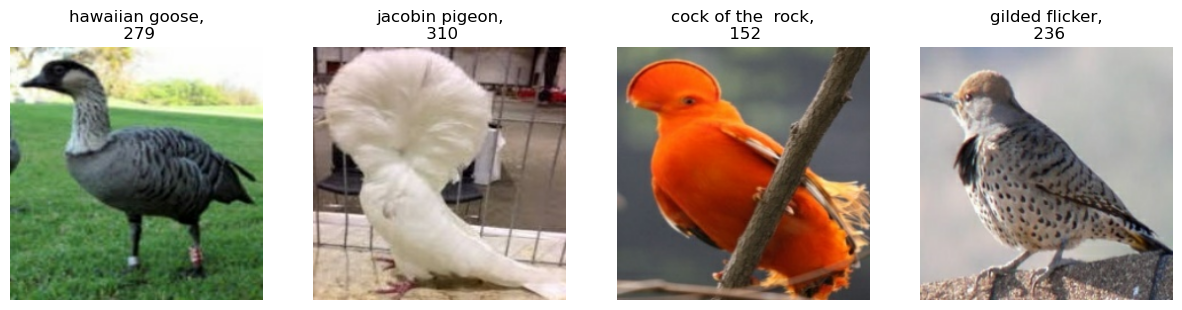

In [43]:
fig, ax = plt.subplots(ncols= 4, figsize=(15, 15))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].axis('off')
    ax[index].set_title(str(class_names[batch[1][index]]) +",\n "+  str(batch[1][index]))
plt.show()

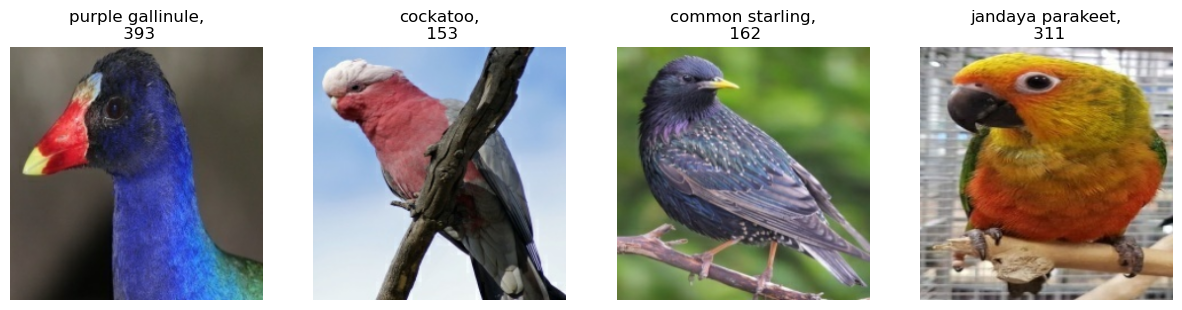

In [64]:
# We want to scale the data so it is between 0 and 1
# This is done because it is easier for the model to learn the weights
# The model will learn the weights faster because the gradients will be smaller

training_data_scaled = training_data.map(lambda x, y: (x/255, y)).as_numpy_iterator()
validation_data_scaled = validation_data.map(lambda x, y: (x/255, y)).as_numpy_iterator()
testing_data_scaled = testing_data.map(lambda x, y: (x/255, y)).as_numpy_iterator()

batch = training_data_scaled.next()
# Another look at the data to make sure it is scaled correctly
fig, ax = plt.subplots(ncols= 4, figsize=(15, 15))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img)
    ax[index].axis('off')
    ax[index].set_title(str(class_names[batch[1][index]]) +",\n "+  str(batch[1][index]))
plt.show()

In [65]:
# Creating the Convolutional Neural Network model
model = Sequential()
model.add(Conv2D(32, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# The lenght of the class names is the number of classes we have
model.add(Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 32)       

In [66]:
#train the neural net
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1)

In [67]:
#fitting the model
history = model.fit(training_data_scaled, validation_data=validation_data_scaled, epochs=10, steps_per_epoch= 84635//10, callbacks=[tensorboard_callback])

Epoch 1/10


2023-09-16 18:25:04.339914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2644/8463 [========>.....................] - ETA: 5:19 - loss: 5.4308 - accuracy: 0.1050WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 84630 batches). You may need to use the repeat() function when building your dataset.


2023-09-16 18:27:29.618064: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7478658103916138496
2023-09-16 18:27:29.618082: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4794449469175979606
2023-09-16 18:27:29.618085: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 223893342525430203
2023-09-16 18:27:29.618097: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7349318948390580969
2023-09-16 18:27:29.740261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-16 18:27:31.064727: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7673608729384886611
2023-09-16 18:27:31.064742: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous rec

8463/8463 [==============================] - 147s 17ms/step - loss: 5.4308 - accuracy: 0.1050 - val_loss: 4.5330 - val_accuracy: 0.2518


In [38]:
histotry.history

NameError: name 'histotry' is not defined

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()